In [7]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import numpy as np

In [8]:
# Function to parse the flow info log
def parse_flow_info_log(flow_info_file):
    flows = {}
    with open(flow_info_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            flow_id = int(parts[0])
            flows[flow_id] = {
                'start_time': int(parts[6]),
                'end_time': int(parts[6]) + int(parts[7]),  # end_time = start_time + fct
                'links': set(),
                'size': int(parts[5])
            }
    return flows

# Function to parse the link info log
def parse_link_info_log(link_info_file):
    link_flows = defaultdict(set)
    with open(link_info_file, 'r') as file:
        num_links = int(file.readline().strip())
        for _ in range(num_links):
            link_info = list(map(int, file.readline().strip().split(',')))
            flow_ids = list(map(int, file.readline().strip().split(',')[:-1]))
            assert link_info[3] == len(flow_ids)
            link = (link_info[1], link_info[2])
            link_flows[link].update(flow_ids)
    return link_flows

# Optimized function to assign links to flows
def assign_links_to_flows(flows, link_flows):
    for link, flow_ids in link_flows.items():
        for flow_id in flow_ids:
            if flow_id in flows:
                flows[flow_id]['links'].add(link)
    return flows

# Function to update bipartite graph and calculate busy periods
def update_bipartite_graph_and_calculate_busy_periods(flows):
    active_graphs = {}  # Dictionary to hold multiple bipartite graphs with graph_id as key
    busy_periods = []  # List to store busy periods
    events = []

    # Precompute events
    for flow_id, flow in flows.items():
        events.append((flow['start_time'], 'start', flow_id, flow['links']))
        events.append((flow['end_time'], 'end', flow_id, flow['links']))

    events.sort()

    link_to_graph = {}  # Map to quickly find which graph a link belongs to
    graph_id_new = 0  # Unique identifier for each graph
    for time, event, flow_id, links in events:
        cur_time = time 
        if flow_id % 1000 == 0:
            print(f'Processing flow {flow_id}')
        if event == 'start':
            # Find all graphs involved with the new flow's links
            involved_graph_ids = set()
            for link in links:
                if link in link_to_graph:
                    involved_graph_ids.add(link_to_graph[link])

            new_active_links = defaultdict(set)
            new_all_links = set()
            new_flows = set()
            new_all_flows = set()
            
            if involved_graph_ids:
                for gid in involved_graph_ids:
                    graph = active_graphs[gid]
                    new_active_links.update(graph['active_links'])
                    new_all_links.update(graph['all_links'])
                    new_flows.update(graph['active_flows'])
                    new_all_flows.update(graph['all_flows'])
                    if cur_time > graph['start_time']:
                        cur_time = graph['start_time']
                    
                    for link in graph['active_links']:
                        link_to_graph[link] = graph_id_new
                    del active_graphs[gid]
            
            for link in links:
                new_active_links[link].add(flow_id)
                new_all_links.add(link)
                link_to_graph[link] = graph_id_new
            new_flows.add(flow_id)
            new_all_flows.add(flow_id)
            active_graphs[graph_id_new] = {
                'active_links': new_active_links,
                'all_links': new_all_links,
                'active_flows': new_flows,
                'all_flows': new_all_flows,
                'start_time': cur_time
            }
            graph_id_new += 1

        elif event == 'end':
            graph = None
            for link in links:
                if link in link_to_graph:
                    graph_id = link_to_graph[link]
                    graph = active_graphs[graph_id]
                    break

            if graph:
                for link in links:
                    if flow_id in graph['active_links'][link]:
                        graph['active_links'][link].remove(flow_id)
                        if not graph['active_links'][link]:
                            del graph['active_links'][link]
                            del link_to_graph[link]
                    else:
                        assert False, f"Flow {flow_id} not found in link {link} of graph {graph_id}"
                if flow_id in graph['active_flows']:
                    graph['active_flows'].remove(flow_id)
                else:
                    assert False, f"Flow {flow_id} not found in active flows of graph {graph_id}"
                if not graph['active_flows']:  # If no active flows left in the graph
                    if len(graph['all_flows']) > 0:  # If there is more than one flow in the graph
                        busy_periods.append((graph['start_time'], cur_time, list(graph['all_links']), list(graph['all_flows'])))
                    del active_graphs[graph_id]
                    for link in graph['active_links']:
                        del link_to_graph[link]
            else:
                assert False, f"Flow {flow_id} has no active graph"
    return busy_periods

def update_bipartite_graph_and_calculate_busy_periods_small_flows(flows,flow_size_threshold):
    active_graphs = {}  # Dictionary to hold multiple bipartite graphs with graph_id as key
    busy_periods = []  # List to store busy periods
    busy_periods_len = []
    busy_periods_unique = set()
    events = []

    # Precompute events
    flow_to_end_time={}
    for flow_id, flow in flows.items():
        events.append((flow['start_time'], 'start', flow_id, flow['links'],flow['size']))
        events.append((flow['end_time'], 'end', flow_id, flow['links'], flow['size']))
        flow_to_end_time[flow_id]=flow['end_time']

    events.sort()

    link_to_graph = {}  # Map to quickly find which graph a link belongs to
    graph_id_new = 0  # Unique identifier for each graph
    large_flow_to_info = {}
    flow_to_size={}
    
    for time, event, flow_id, links, size in events:
        cur_time = time 
        if flow_id % 1000 == 0:
            print(f'Processing flow {flow_id}')
        if event == 'start':
            flow_to_size[flow_id]=size
            if size > flow_size_threshold:
                large_flow_to_info[flow_id] = (time,links)
                involved_graph_ids = set()
                for link in links:
                    if link in link_to_graph:
                        involved_graph_ids.add(link_to_graph[link])
                if involved_graph_ids:
                    for gid in involved_graph_ids:
                        graph = active_graphs[gid]
                        graph["all_links"].add(link)
                        graph["all_flows"].add(flow_id)
            else:
                new_active_links = defaultdict(set)
                new_all_links = set()
                new_flows = set()
                new_all_flows = set()
                
                # Find all graphs involved with the new flow's links
                involved_graph_ids = set()
                for link in links:
                    if link in link_to_graph:
                        involved_graph_ids.add(link_to_graph[link])
                
                if involved_graph_ids:
                    for gid in involved_graph_ids:
                        graph = active_graphs[gid]
                        new_active_links.update(graph['active_links'])
                        new_all_links.update(graph['all_links'])
                        new_flows.update(graph['active_flows'])
                        new_all_flows.update(graph['all_flows'])
                        if cur_time > graph['start_time']:
                            cur_time = graph['start_time']
                        
                        for link in graph['active_links']:
                            link_to_graph[link] = graph_id_new
                        del active_graphs[gid]
            
                for link in links:
                    new_active_links[link].add(flow_id)
                    new_all_links.add(link)
                    link_to_graph[link] = graph_id_new
                new_flows.add(flow_id)
                new_all_flows.add(flow_id)
                active_graphs[graph_id_new] = {
                    'active_links': new_active_links,
                    'all_links': new_all_links,
                    'active_flows': new_flows,
                    'all_flows': new_all_flows,
                    'start_time': cur_time
                }
                graph_id_new += 1

        elif event == 'end':
            graph = None 
            flow_to_size.pop(flow_id)
            if flow_id in large_flow_to_info:
                large_flow_to_info.pop(flow_id)
                involved_graph_ids = set()
                for link in links:
                    if link in link_to_graph:
                        involved_graph_ids.add(link_to_graph[link])
                if involved_graph_ids:
                    for gid in involved_graph_ids:
                        graph = active_graphs[gid]
                        graph["all_links"].add(link)
                        graph["all_flows"].add(flow_id)
                continue
                           
            for link in links:
                if link in link_to_graph:
                    graph_id = link_to_graph[link]
                    graph = active_graphs[graph_id]
                    break

            if graph:
                for link in links:
                    if flow_id in graph['active_links'][link]:
                        graph['active_links'][link].remove(flow_id)
                        if not graph['active_links'][link]:
                            del graph['active_links'][link]
                            del link_to_graph[link]
                    else:
                        assert False, f"Flow {flow_id} not found in link {link} of graph {graph_id}"
                if flow_id in graph['active_flows']:
                    graph['active_flows'].remove(flow_id)
                else:
                    assert False, f"Flow {flow_id} not found in active flows of graph {graph_id}"
                # if not graph['active_flows']:  # If no active flows left in the graph
                n_small_flows=len([flow_id for flow_id in graph['active_flows'] if flow_to_size[flow_id]<=flow_size_threshold])
                # n_large_flows=len(graph['active_flows'])-n_small_flows
                assert n_small_flows == len(
                    graph["active_flows"]
                ), f"n_small_flows: {n_small_flows}, n_active_flows: {len(graph['active_flows'])}"
                if n_small_flows==0:  # If no active flows left in the graph
                    end_time=cur_time
                    # for flow_id in graph['active_flows']:
                    #     if flow_to_end_time[flow_id]>end_time:
                    #         end_time=flow_to_end_time[flow_id]
                    busy_periods.append((graph['start_time'], end_time, list(graph['all_links']), list(graph['all_flows'])))
                    busy_periods_len.append(len(graph['all_flows']))
                    busy_periods_unique.update(graph['all_flows'])
                    
                    del active_graphs[graph_id]
                    for link in graph['active_links']:
                        del link_to_graph[link]
                        
                    # if n_large_flows>0:
                    #     new_active_links = defaultdict(set)
                    #     new_all_links = set()
                    #     new_flows = graph['active_flows']
                    #     new_all_flows = graph['active_flows']
                    #     start_time=cur_time
                    #     for flow_id in graph['active_flows']:
                    #         for link in large_flow_to_info[flow_id][1]:
                    #             new_active_links[link].add(flow_id)
                    #             new_all_links.add(link)
                    #             link_to_graph[link] = graph_id_new
                    #         # if large_flow_to_info[flow_id][0]<start_time:
                    #         #     start_time=large_flow_to_info[flow_id][0]
                    #     active_graphs[graph_id_new] = {
                    #         'active_links': new_active_links,
                    #         'all_links': new_all_links,
                    #         'active_flows': new_flows,
                    #         'all_flows': new_all_flows,
                    #         'start_time': start_time
                    #     }
                    #     graph_id_new += 1
            else:
                assert False, f"Flow {flow_id} has no active graph"
    print(
        f"n_flow_event: {len(events)}, {len(busy_periods)} busy periods, flow_size_threshold: {flow_size_threshold}, n_flows_unique: {len(busy_periods_unique)} , n_flows_per_period_est: {np.min(busy_periods_len)}, {np.mean(busy_periods_len)}, {np.max(busy_periods_len)}"
    )
    return busy_periods

# Function to save results to a file
def save_results(filename, busy_periods):
    with open(filename, 'w') as file:
        json.dump(busy_periods, file)

# Function to read results from a file
def read_results(filename):
    with open(filename, 'r') as file:
        return json.load(file)

In [9]:
# Function to plot the CDF
def plot_cdf(data, xlabel, ylabel, title,ax):
    data_sorted = np.sort(data)
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    ax.plot(data_sorted, cdf, marker='.', linestyle='none')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

# Function to plot the relationship between number of flows and number of links
def plot_relationship(x_data, y_data, xlabel, ylabel, title,ax):
    ax.scatter(x_data, y_data, alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

# Function to plot the number of busy periods over time
def plot_busy_periods_over_time(busy_periods,ax):
    events = []

    for start_time, end_time, links, all_flows in busy_periods:
        events.append((start_time, 'start'))
        events.append((end_time, 'end'))

    events.sort()
    busy_count = 0
    times = []
    counts = []

    for time, event in events:
        if event == 'start':
            busy_count += 1
        elif event == 'end':
            busy_count -= 1
        times.append(time)
        counts.append(busy_count)

    ax.plot(times, counts, drawstyle='steps-post')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Busy Periods')
    ax.set_title('Number of Busy Periods Over Time')
    ax.grid(True)

def plot_active_flows_during_longest_period(busy_periods,flows_info,ax):
    # Find the longest busy period
    busiest_period = max(busy_periods, key=lambda x: len(x[3]))  # x[3] contains the flows
    start_time, end_time, _, all_flows = busiest_period

    # Collect start and end times of flows within the longest busy period
    events = []
    print(f'Longest busy period: {len(all_flows)} flows, from  {start_time} to {end_time}')
    for flow_id in all_flows:
        flow = flows_info[flow_id]
        flow_start = flow['start_time']
        flow_end = flow['end_time']
        assert not (flow_start > end_time or flow_end < start_time)
        events.append((flow_start, 'start'))
        events.append((flow_end, 'end'))

    events.sort()

    # Calculate the number of active flows over time
    active_flows = 0
    times = []
    counts = []

    for time, event in events:
        if event == 'start':
            active_flows += 1
        elif event == 'end':
            active_flows -= 1
        times.append(time)
        counts.append(active_flows)

    # Plot the number of active flows over time
    ax.step(times, counts, where='post', label='Active Flows')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Active Flows')
    ax.set_title('Number of Active Flows During the Longest Busy Period')
    ax.grid(True)
    ax.legend()

def plot_active_links_during_longest_period(busy_periods, flows_data,ax):
    # Find the longest busy period
    busiest_period = max(busy_periods, key=lambda x: len(x[3]))  # x[3] contains the flows
    start_time, end_time, _, all_flows = busiest_period

    # Collect start and end times of flows within the longest busy period
    events = []
    for flow_id in all_flows:
        flow = flows_data[flow_id]
        flow_start = flow['start_time']
        flow_end = flow['end_time']
        assert not (flow_start > end_time or flow_end < start_time)
        events.append((flow_start, 'start', flow['links'],flow_id))
        events.append((flow_end, 'end', flow['links'],flow_id))

    events.sort()

    # Calculate the number of active links over time
    active_links = defaultdict(set)
    times = []
    counts = []

    for time, event, links,flow_id in events:
        if event == 'start':
            for link in links:
                active_links[link].add(flow_id)
        elif event == 'end':
            for link in links:
                active_links[link].remove(flow_id)
                if not active_links[link]:
                    del active_links[link]
        times.append(time)
        counts.append(len(active_links))

    # Plot the number of active links over time
    ax.step(times, counts, where='post', label='Active Links')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Active Links')
    ax.set_title('Number of Active Links During the Longest Busy Period')
    ax.grid(True)
    ax.legend()


Parsed 199995 flows
Parsed 128 links
Processing flow 0
Processing flow 0
Processing flow 1000
Processing flow 1000
Processing flow 2000
Processing flow 2000
Processing flow 3000
Processing flow 3000
Processing flow 4000
Processing flow 4000
Processing flow 5000
Processing flow 5000
Processing flow 6000
Processing flow 6000
Processing flow 7000
Processing flow 7000
Processing flow 8000
Processing flow 8000
Processing flow 9000
Processing flow 9000
Processing flow 10000
Processing flow 10000
Processing flow 11000
Processing flow 11000
Processing flow 12000
Processing flow 12000
Processing flow 13000
Processing flow 13000
Processing flow 14000
Processing flow 14000
Processing flow 15000
Processing flow 15000
Processing flow 16000
Processing flow 16000
Processing flow 17000
Processing flow 17000
Processing flow 18000
Processing flow 18000
Processing flow 19000
Processing flow 19000
Processing flow 20000
Processing flow 20000
Processing flow 21000
Processing flow 21000
Processing flow 22000

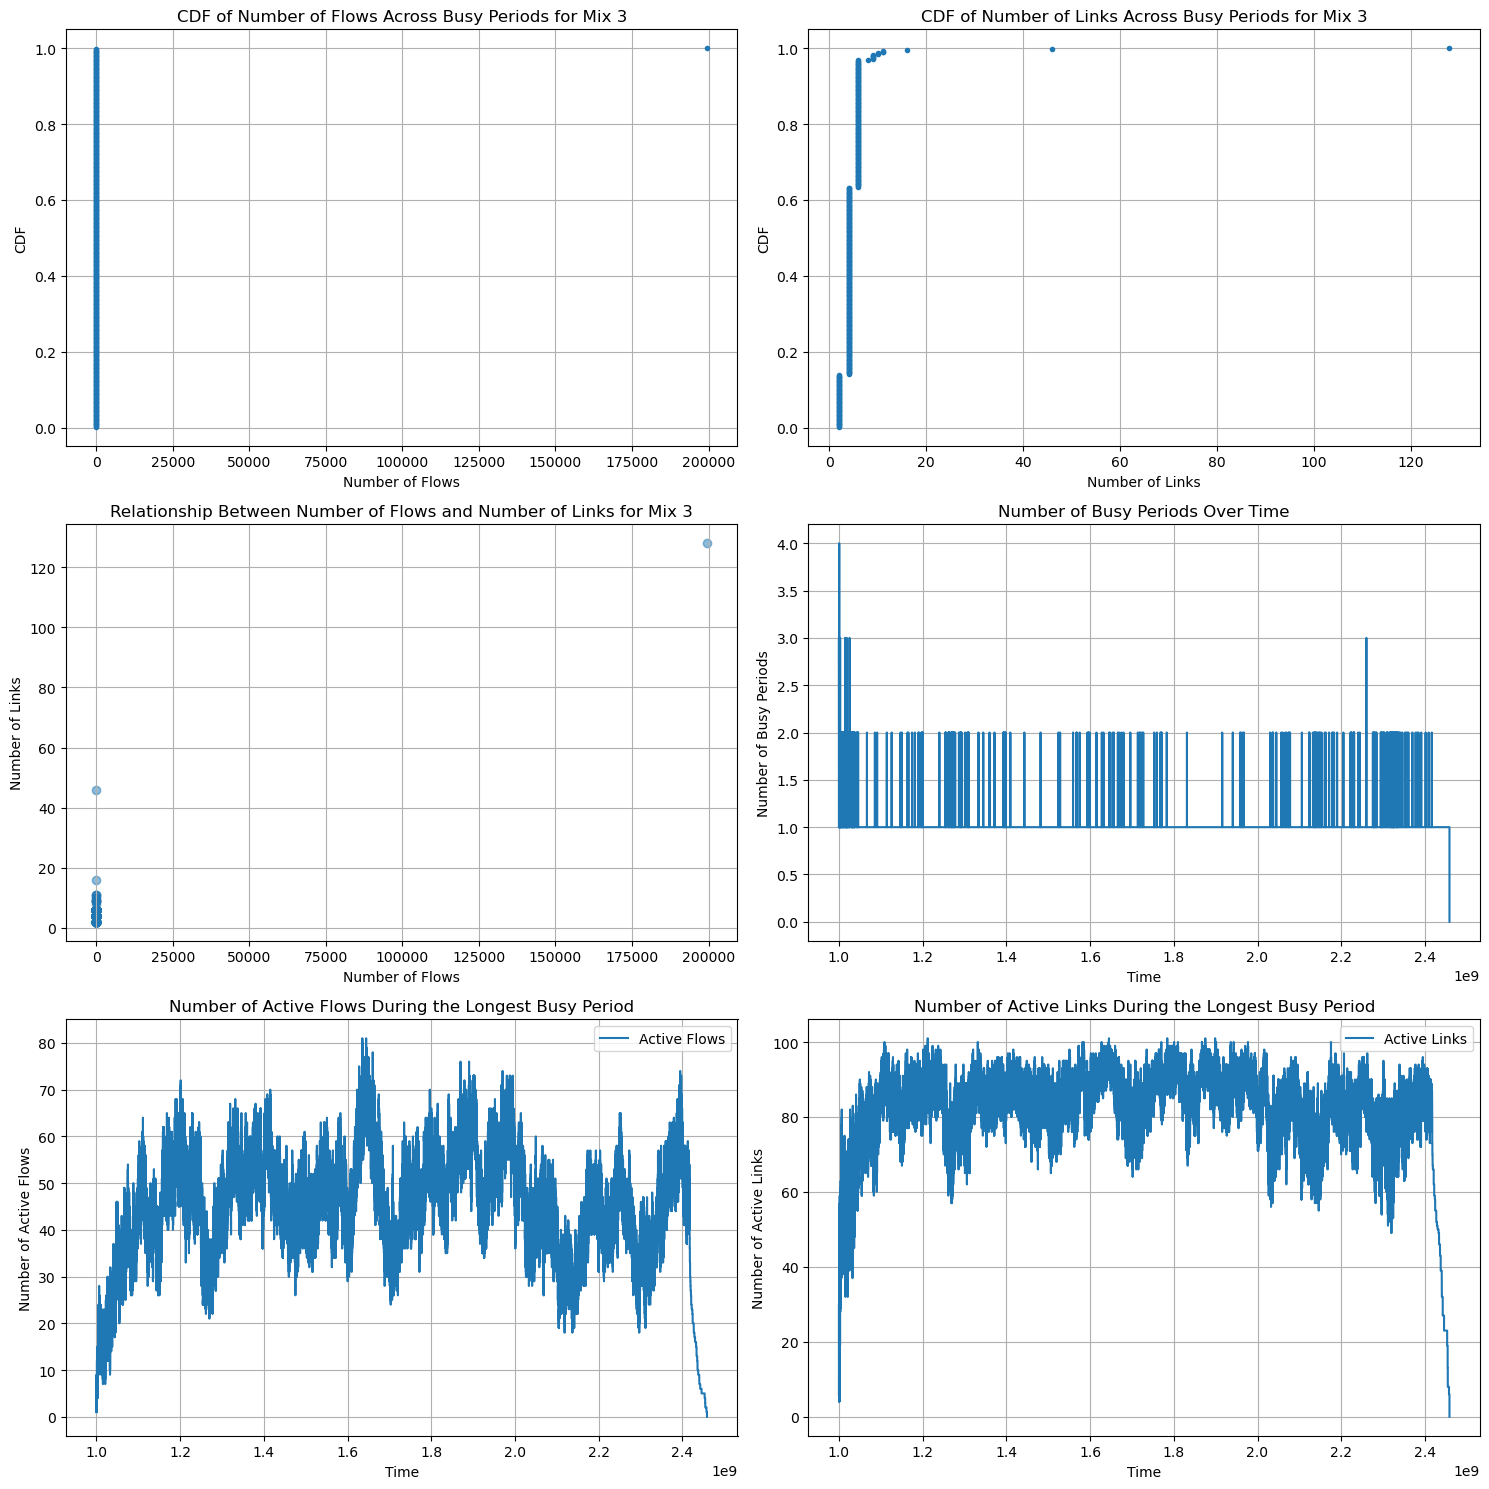

In [11]:
root_dir = '../data/'  # Update with the path to your root directory
flow_size_threshold=100000000
mix_list = [3]
for mix_id in mix_list:
    flow_info_file = f"{root_dir}{mix_id}/ns3/fct_topology_flows_dctcp.txt"
    link_info_file = f"{root_dir}{mix_id}/mlsys-test/path_0.txt"
    result_file = f"./res/busy_periods_{mix_id}_t{flow_size_threshold}.json"

    # Parse logs
    if os.path.exists(result_file):
        busy_periods = read_results(result_file)
    else:
        flows = parse_flow_info_log(flow_info_file)
        print(f'Parsed {len(flows)} flows')
        link_flows = parse_link_info_log(link_info_file)
        print(f'Parsed {len(link_flows)} links')
        
        # Assign links to flows
        flows = assign_links_to_flows(flows, link_flows)
        
        # Update bipartite graph and calculate busy periods
        # busy_periods = update_bipartite_graph_and_calculate_busy_periods(flows)
        busy_periods = update_bipartite_graph_and_calculate_busy_periods_small_flows(flows,flow_size_threshold)
        
        # Save results
        # save_results(result_file, busy_periods)
        print(f'Saved results to {result_file}')
    print(f'Found {len(busy_periods)} busy periods')
    # Plot CDF of number of flows across busy periods
    num_flows = [len(period[3]) for period in busy_periods]
    print(f"sum of number of flows: {sum(num_flows)}")
    index_max=num_flows.index(max(num_flows))
    print(f"max number of flows: {max(num_flows)} with index {index_max} and links {len(busy_periods[index_max][2])}")
    
    num_links = [len(period[2]) for period in busy_periods]
    
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    
    plot_cdf(num_flows, 'Number of Flows', 'CDF', f'CDF of Number of Flows Across Busy Periods for Mix {mix_id}', axs[0, 0])
    plot_cdf(num_links, 'Number of Links', 'CDF', f'CDF of Number of Links Across Busy Periods for Mix {mix_id}', axs[0, 1])
    plot_relationship(num_flows, num_links, 'Number of Flows', 'Number of Links', f'Relationship Between Number of Flows and Number of Links for Mix {mix_id}', axs[1, 0])
    plot_busy_periods_over_time(busy_periods, axs[1, 1])
    
    
    flows = parse_flow_info_log(flow_info_file)
    link_flows = parse_link_info_log(link_info_file)
    flows = assign_links_to_flows(flows, link_flows)
        
    plot_active_flows_during_longest_period(busy_periods, flows, axs[2, 0])
    
    plot_active_links_during_longest_period(busy_periods, flows, axs[2, 1])
    
    plt.tight_layout()
    plt.show()

Parsed 199995 flows
Parsed 104 links
Processing flow 0
Processing flow 0
Processing flow 1000
Processing flow 1000
Processing flow 2000
Processing flow 2000
Processing flow 3000
Processing flow 3000
Processing flow 4000
Processing flow 4000
Processing flow 5000
Processing flow 5000
Processing flow 6000
Processing flow 6000
Processing flow 7000
Processing flow 7000
Processing flow 8000
Processing flow 8000
Processing flow 9000
Processing flow 9000
Processing flow 10000
Processing flow 10000
Processing flow 11000
Processing flow 11000
Processing flow 12000
Processing flow 12000
Processing flow 13000
Processing flow 13000
Processing flow 14000
Processing flow 14000
Processing flow 15000
Processing flow 15000
Processing flow 16000
Processing flow 16000
Processing flow 17000
Processing flow 17000
Processing flow 18000
Processing flow 18000
Processing flow 19000
Processing flow 19000
Processing flow 20000
Processing flow 20000
Processing flow 21000
Processing flow 21000
Processing flow 22000

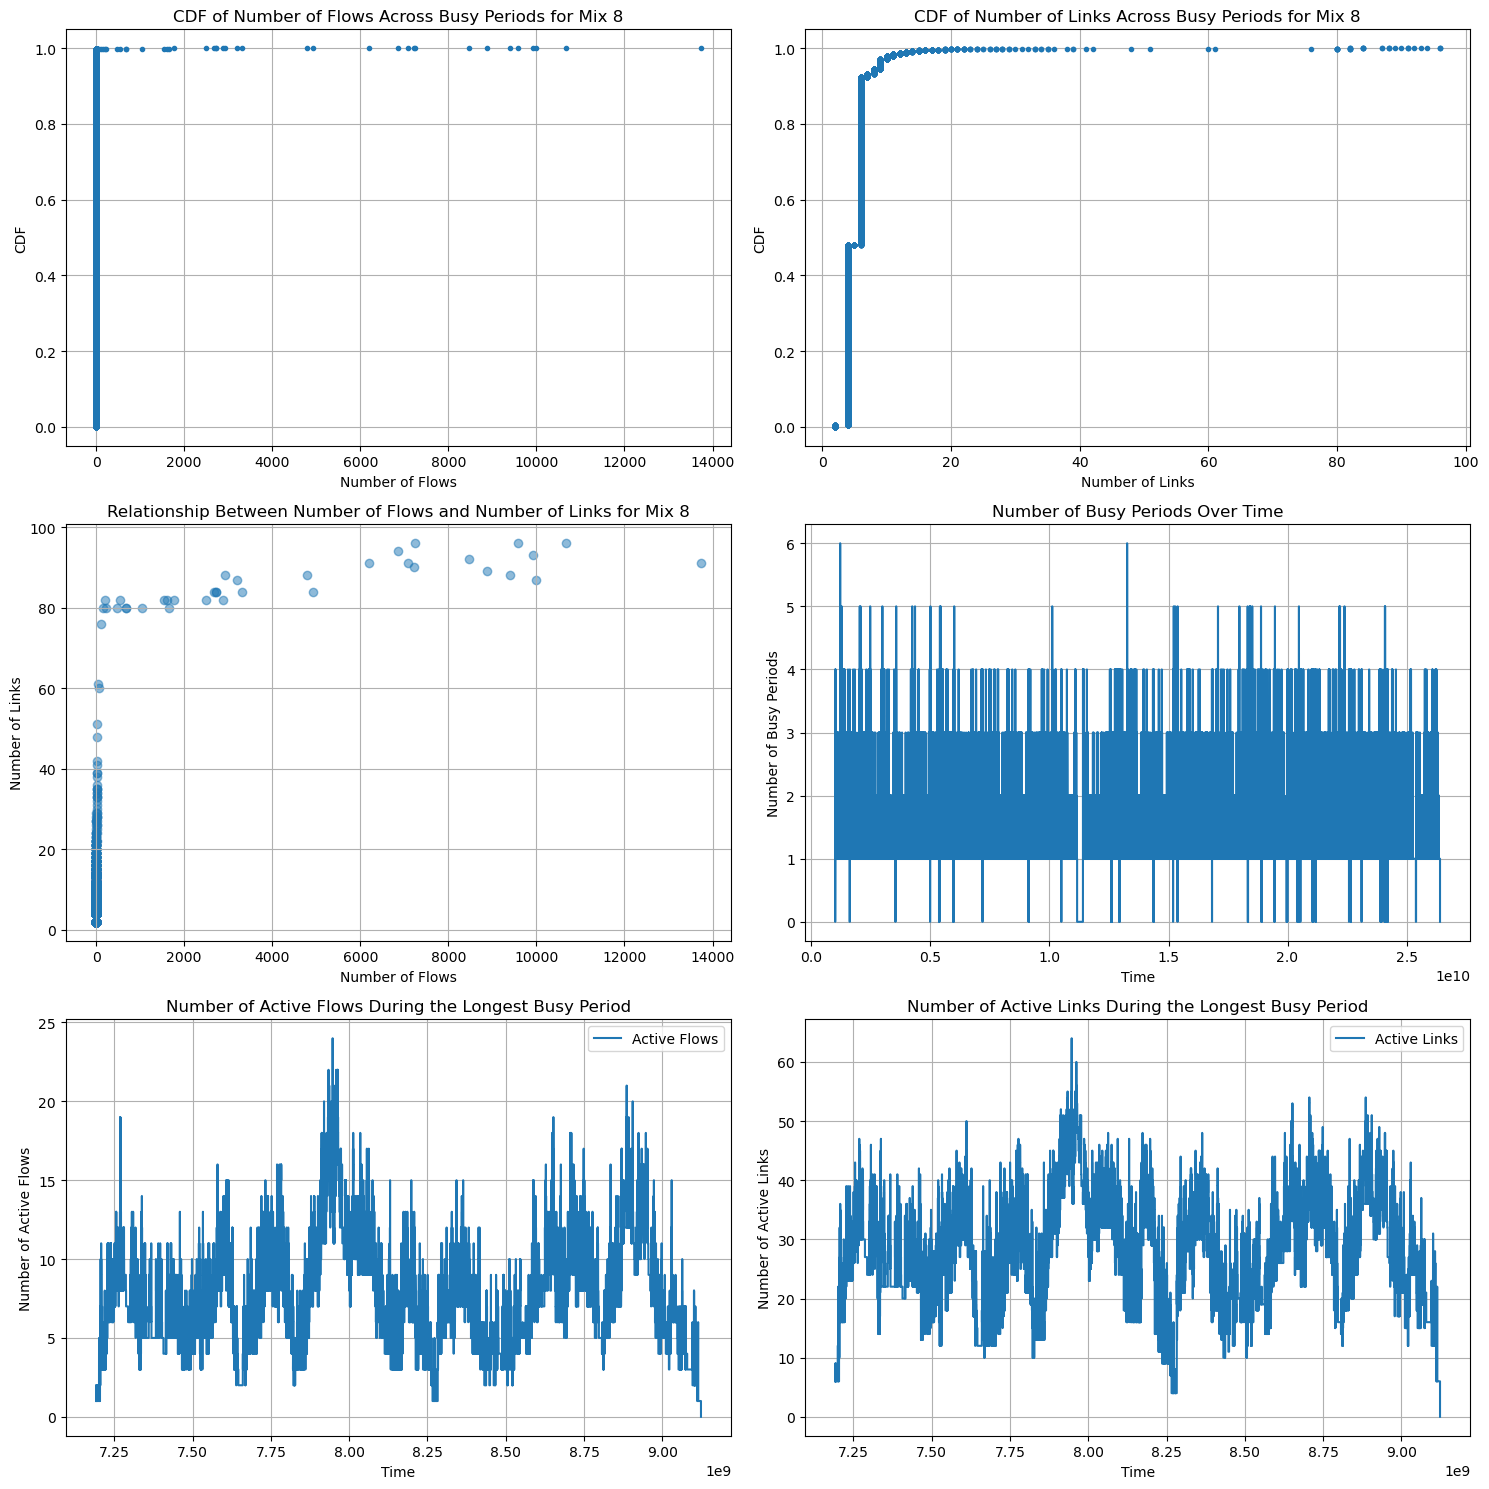

In [14]:
root_dir = '../data/'  # Update with the path to your root directory
flow_size_threshold=100000000
mix_list = [8]
for mix_id in mix_list:
    flow_info_file = f"{root_dir}{mix_id}/ns3/fct_topology_flows_dctcp.txt"
    link_info_file = f"{root_dir}{mix_id}/mlsys-test/path_0.txt"
    result_file = f"./res/busy_periods_{mix_id}_t{flow_size_threshold}.json"

    # Parse logs
    if os.path.exists(result_file):
        busy_periods = read_results(result_file)
    else:
        flows = parse_flow_info_log(flow_info_file)
        print(f'Parsed {len(flows)} flows')
        link_flows = parse_link_info_log(link_info_file)
        print(f'Parsed {len(link_flows)} links')
        
        # Assign links to flows
        flows = assign_links_to_flows(flows, link_flows)
        
        # Update bipartite graph and calculate busy periods
        # busy_periods = update_bipartite_graph_and_calculate_busy_periods(flows)
        busy_periods = update_bipartite_graph_and_calculate_busy_periods_small_flows(flows,flow_size_threshold)
        
        # Save results
        # save_results(result_file, busy_periods)
        print(f'Saved results to {result_file}')
    print(f'Found {len(busy_periods)} busy periods')
    # Plot CDF of number of flows across busy periods
    num_flows = [len(period[3]) for period in busy_periods]
    print(f"sum of number of flows: {sum(num_flows)}")
    index_max=num_flows.index(max(num_flows))
    print(f"max number of flows: {max(num_flows)} with index {index_max} and links {len(busy_periods[index_max][2])}")
    
    num_links = [len(period[2]) for period in busy_periods]
    
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    
    plot_cdf(num_flows, 'Number of Flows', 'CDF', f'CDF of Number of Flows Across Busy Periods for Mix {mix_id}', axs[0, 0])
    plot_cdf(num_links, 'Number of Links', 'CDF', f'CDF of Number of Links Across Busy Periods for Mix {mix_id}', axs[0, 1])
    plot_relationship(num_flows, num_links, 'Number of Flows', 'Number of Links', f'Relationship Between Number of Flows and Number of Links for Mix {mix_id}', axs[1, 0])
    plot_busy_periods_over_time(busy_periods, axs[1, 1])
    
    
    flows = parse_flow_info_log(flow_info_file)
    link_flows = parse_link_info_log(link_info_file)
    flows = assign_links_to_flows(flows, link_flows)
        
    plot_active_flows_during_longest_period(busy_periods, flows, axs[2, 0])
    
    plot_active_links_during_longest_period(busy_periods, flows, axs[2, 1])
    
    plt.tight_layout()
    plt.show()

Parsed 199995 flows
Parsed 128 links
Processing flow 0
Processing flow 0
Processing flow 1000
Processing flow 1000
Processing flow 2000
Processing flow 2000
Processing flow 3000
Processing flow 3000
Processing flow 4000
Processing flow 4000
Processing flow 5000
Processing flow 5000
Processing flow 6000
Processing flow 6000
Processing flow 7000
Processing flow 7000
Processing flow 8000
Processing flow 8000
Processing flow 9000
Processing flow 9000
Processing flow 10000
Processing flow 10000
Processing flow 11000
Processing flow 11000
Processing flow 12000
Processing flow 12000
Processing flow 13000
Processing flow 13000
Processing flow 14000
Processing flow 14000
Processing flow 15000
Processing flow 15000
Processing flow 16000
Processing flow 16000
Processing flow 17000
Processing flow 17000
Processing flow 18000
Processing flow 18000
Processing flow 19000
Processing flow 19000
Processing flow 20000
Processing flow 20000
Processing flow 21000
Processing flow 21000
Processing flow 22000

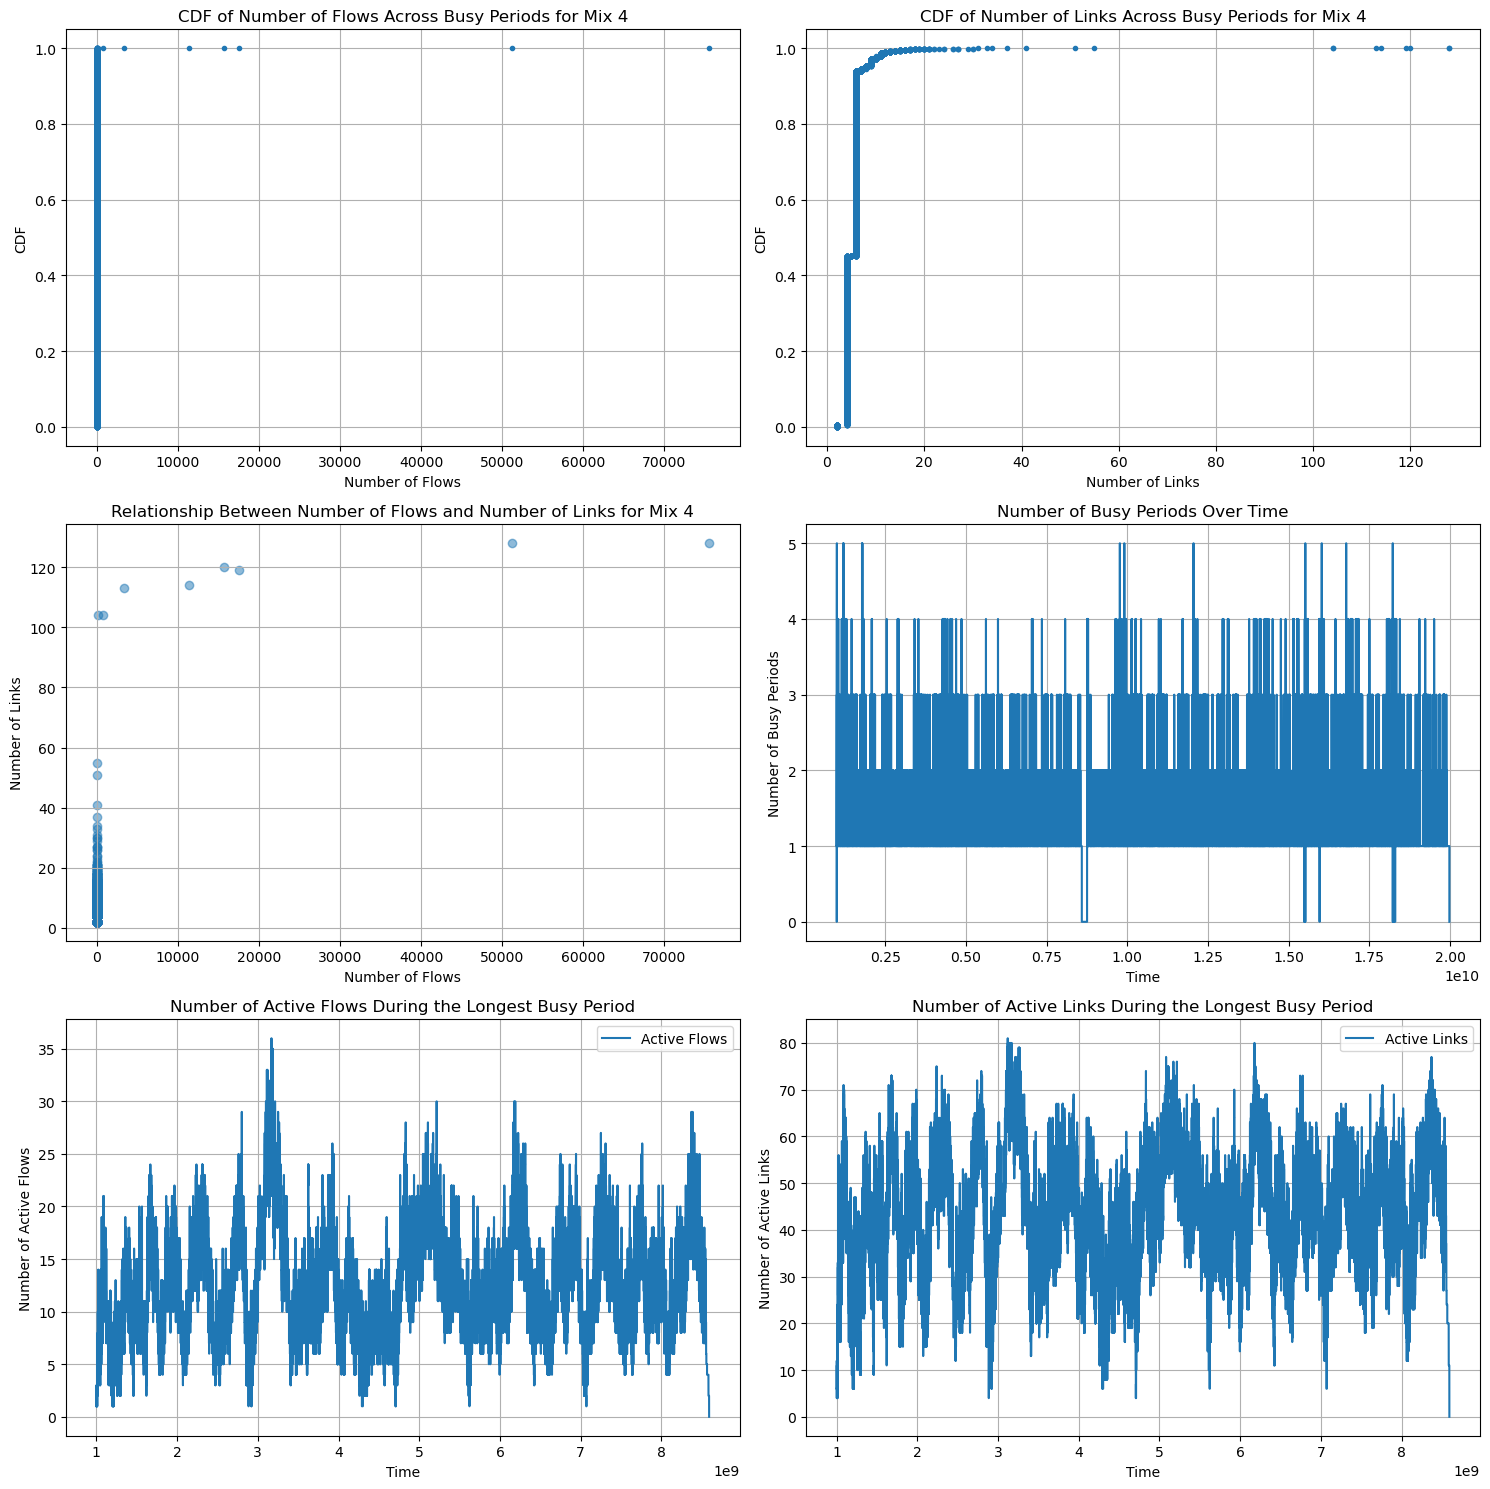

In [13]:
root_dir = '../data/'  # Update with the path to your root directory
flow_size_threshold=100000000
mix_list = [4]
for mix_id in mix_list:
    flow_info_file = f"{root_dir}{mix_id}/ns3/fct_topology_flows_dctcp.txt"
    link_info_file = f"{root_dir}{mix_id}/mlsys-test/path_0.txt"
    result_file = f"./res/busy_periods_{mix_id}_t{flow_size_threshold}.json"

    # Parse logs
    if os.path.exists(result_file):
        busy_periods = read_results(result_file)
    else:
        flows = parse_flow_info_log(flow_info_file)
        print(f'Parsed {len(flows)} flows')
        link_flows = parse_link_info_log(link_info_file)
        print(f'Parsed {len(link_flows)} links')
        
        # Assign links to flows
        flows = assign_links_to_flows(flows, link_flows)
        
        # Update bipartite graph and calculate busy periods
        # busy_periods = update_bipartite_graph_and_calculate_busy_periods(flows)
        busy_periods = update_bipartite_graph_and_calculate_busy_periods_small_flows(flows,flow_size_threshold)
        
        # Save results
        # save_results(result_file, busy_periods)
        print(f'Saved results to {result_file}')
    print(f'Found {len(busy_periods)} busy periods')
    # Plot CDF of number of flows across busy periods
    num_flows = [len(period[3]) for period in busy_periods]
    print(f"sum of number of flows: {sum(num_flows)}")
    index_max=num_flows.index(max(num_flows))
    print(f"max number of flows: {max(num_flows)} with index {index_max} and links {len(busy_periods[index_max][2])}")
    
    num_links = [len(period[2]) for period in busy_periods]
    
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    
    plot_cdf(num_flows, 'Number of Flows', 'CDF', f'CDF of Number of Flows Across Busy Periods for Mix {mix_id}', axs[0, 0])
    plot_cdf(num_links, 'Number of Links', 'CDF', f'CDF of Number of Links Across Busy Periods for Mix {mix_id}', axs[0, 1])
    plot_relationship(num_flows, num_links, 'Number of Flows', 'Number of Links', f'Relationship Between Number of Flows and Number of Links for Mix {mix_id}', axs[1, 0])
    plot_busy_periods_over_time(busy_periods, axs[1, 1])
    
    
    flows = parse_flow_info_log(flow_info_file)
    link_flows = parse_link_info_log(link_info_file)
    flows = assign_links_to_flows(flows, link_flows)
        
    plot_active_flows_during_longest_period(busy_periods, flows, axs[2, 0])
    
    plot_active_links_during_longest_period(busy_periods, flows, axs[2, 1])
    
    plt.tight_layout()
    plt.show()